# Face Verification using Siamese Neural Network

### 1. Installation 

In [ ]:
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

### 2. Import

In [1]:
import os
import cv2
import uuid
import random
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import get_custom_objects
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

2025-07-07 23:59:37.183953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751925577.216853   68829 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751925577.224290   68829 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751925577.245000   68829 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751925577.245029   68829 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751925577.245033   68829 computation_placer.cc:177] computation placer alr

### 3. GPU Configuration

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


### 4. Directory Setup

In [3]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')
#os.makedirs(POS_PATH, exist_ok=True)
#os.makedirs(NEG_PATH, exist_ok=True)
#os.makedirs(ANC_PATH, exist_ok=True)

### 5. Data Collection (Webcam)

In [4]:
def collect_images():
    cap = cv2.VideoCapture(4)
    while cap.isOpened():
        ret, frame = cap.read()
        frame = frame[120:120+250, 200:200+250, :]

        if cv2.waitKey(1) & 0xFF == ord('a'):
            imgname = os.path.join(ANC_PATH, f'{uuid.uuid1()}.jpg')
            cv2.imwrite(imgname, frame)

        if cv2.waitKey(1) & 0xFF == ord('p'):
            imgname = os.path.join(POS_PATH, f'{uuid.uuid1()}.jpg')
            cv2.imwrite(imgname, frame)

        cv2.imshow('Image Collection', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

### 6. Data Augmentation

In [5]:
def data_aug(img):
    data = []
    for _ in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1, 2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1, 3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(random.randint(0, 100), random.randint(0, 100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(random.randint(0, 100), random.randint(0, 100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9, upper=1, seed=(random.randint(0, 100), random.randint(0, 100)))
        data.append(img)
    return data


### 7. Preprocessing

In [6]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img

def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)


### 8. Build Siamese Model

In [7]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    x = Conv2D(64, (10, 10), activation='relu')(inp)
    x = MaxPooling2D(64, (2, 2), padding='same')(x)
    x = Conv2D(128, (7, 7), activation='relu')(x)
    x = MaxPooling2D(64, (2, 2), padding='same')(x)
    x = Conv2D(128, (4, 4), activation='relu')(x)
    x = MaxPooling2D(64, (2, 2), padding='same')(x)
    x = Conv2D(256, (4, 4), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(4096, activation='sigmoid')(x)
    return Model(inputs=inp, outputs=x, name='embedding')

class L1Dist(Layer):
    def call(self, inputs):
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)

def make_siamese_model():
    input_image = Input(name='input_img', shape=(100, 100, 3))
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    embedding = make_embedding()
    distances = L1Dist()([embedding(input_image), embedding(validation_image)])
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

### 9. Training Setup

In [10]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

# Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt)

@tf.function
def train_step(batch, model):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    grad = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grad, model.trainable_variables))
    return loss

def train(data, model, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print(f'\nEpoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        r, p = Recall(), Precision()
        for idx, batch in enumerate(data):
            loss = train_step(batch, model)
            yhat = model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx + 1)
        print(f'Loss: {loss.numpy():.4f}, Recall: {r.result().numpy():.4f}, Precision: {p.result().numpy():.4f}')
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

def save_model(model, filename='siamesemodel.h5'):
    model.save(f'models/{filename}')
    print(f"Model saved as {filename}")


### 10. Model Evaluation

In [ ]:
def evaluate_model(model, test_data):
    # Get the true labels and predictions
    y_true = []
    y_pred = []
    
    for batch in test_data:
        X = batch[:2]  # Input data
        y = batch[2]   # True labels
        
        # Predict using the model
        y_hat = model.predict(X)
        
        y_true.extend(y.numpy())  # Collect true labels
        y_pred.extend(np.round(y_hat))  # Collect predicted labels (0 or 1)
    
    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    os.makedirs('media', exist_ok=True)
    confusion_matrix_path = os.path.join('media', 'confusion_matrix.jpeg')
    plt.savefig(confusion_matrix_path)
    plt.close()

    print(f"Confusion matrix saved as {confusion_matrix_path}")
    

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')

    roc_curve_path = os.path.join('media', 'roc_curve.jpeg')
    plt.savefig(roc_curve_path)
    plt.close()  # Close the plot

    print(f"ROC curve saved as {roc_curve_path}")


### 11. Train and save the Model


Epoch 1/1


I0000 00:00:1751925684.075481   69134 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751925686.315998   69132 service.cc:152] XLA service 0x7f24d4284cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751925686.316020   69132 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-07-08 00:01:26.326712: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751925688.420041   69132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/steps/st
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/steps/st
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/steps/st
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/steps/st
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/steps/st
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/steps/st
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/steps/st
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/steps/st
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/steps/st
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/steps/st
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s

2025-07-08 00:04:33.703281: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.2820, Recall: 0.8855, Precision: 0.9457
Model saved as siamesemodel.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

2025-07-08 00:05:13.179992: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


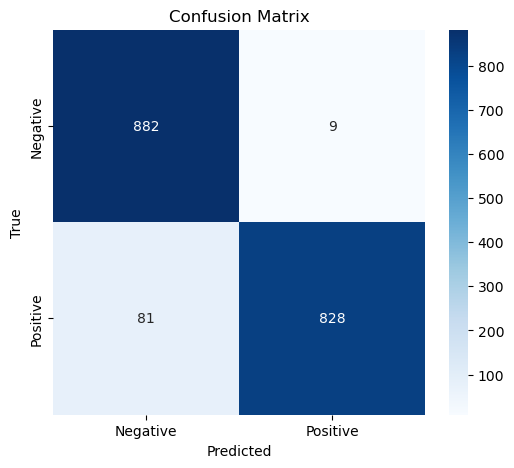

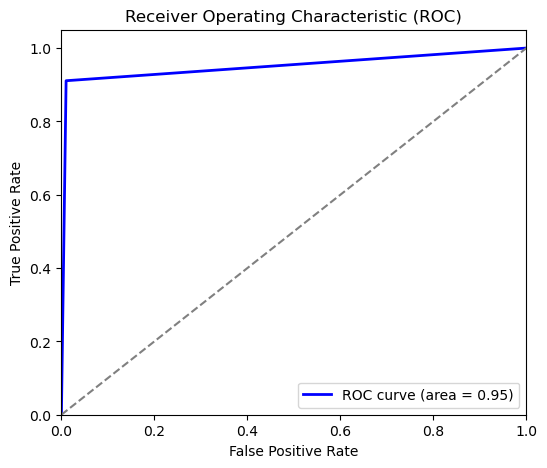

In [12]:
if __name__ == '__main__':
    model = make_siamese_model()

    # Dummy dataset loading and preprocessing
    anchor = tf.data.Dataset.list_files(os.path.join('data', 'anchor', '*.jpg')).take(3000)
    positive = tf.data.Dataset.list_files(os.path.join('data', 'positive', '*.jpg')).take(3000)
    negative = tf.data.Dataset.list_files(os.path.join('data', 'negative', '*.jpg')).take(3000)

    positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
    negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
    data = positives.concatenate(negatives)
    data = data.map(preprocess_twin).cache().shuffle(10000)

    train_data = data.take(round(len(data)*.7)).batch(16).prefetch(8)
    test_data = data.skip(round(len(data)*.7)).take(round(len(data)*.3)).batch(16).prefetch(8)

    # Train the model
    train(train_data, model, EPOCHS=1)

    # Save the trained model as .h5 file
    save_model(model, 'siamesemodel.h5')

    # Evaluate the model on test data and visualize results
    evaluate_model(model, test_data)


### 12. Real-time Verification Functions

In [13]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(results)
    return results, verification > verification_threshold

def real_time_verification(model):
    cap = cv2.VideoCapture(0)  # Use correct camera index
    while cap.isOpened():
        ret, frame = cap.read()
        frame = frame[120:120+250, 200:200+250, :]
        cv2.imshow('Verification', frame)
        if cv2.waitKey(10) & 0xFF == ord('v'):
            cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
            _, verified = verify(model, 0.5, 0.5)
            print('Verified:', verified)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

### 13. Real-time Verification

In [ ]:
get_custom_objects().update({'L1Dist': L1Dist})

if __name__ == '__main__':
    # Load the trained model
    model = load_model('models/siamesemodel.h5')

    # Run real-time verification
    real_time_verification(model)